In [1]:
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')

In [2]:
df = pd.read_feather('data/clean_data_full.ftr')

print(df.shape)
print(f"Total items: {len(df['product_name'].unique())}, Total Orders: {len(df['order_id'].unique())}")
df.head()

(1384617, 2)
Total items: 39123, Total Orders: 131209


,order_id,product_name
0,1,Bulgarian Yogurt
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
4,1,Lightly Smoked Sardines in Olive Oil


In [3]:
# filter out orders have only 1 item & buyers have 1 order
mask = df['order_id'].value_counts()
df = df[df['order_id'].isin(mask.index[mask > 1])]

mask = df.groupby('product_name')['order_id'].count()
df = df[df['product_name'].isin(mask.index[mask > 1])]

In [4]:
df.head()

,order_id,product_name
0,1,Bulgarian Yogurt
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
4,1,Lightly Smoked Sardines in Olive Oil


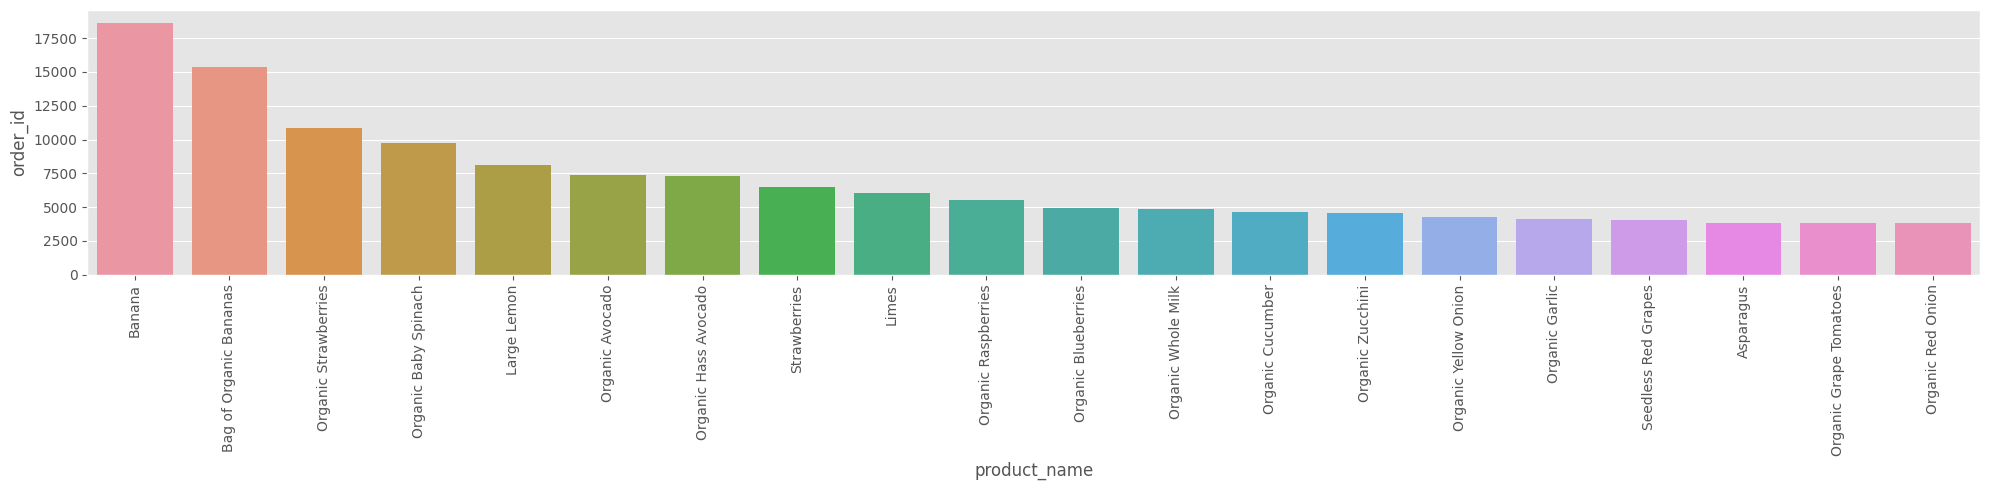

In [6]:
tmp = df.groupby('product_name')['order_id'].count().reset_index()

plt.figure(figsize=(20, 5))
ax = sns.barplot(data=tmp.sort_values(by='order_id', ascending=False).head(20), x='product_name', y='order_id')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.savefig('media/fig2_data_overview.png')

In [6]:
df_txn = df.groupby('order_id')['product_name'].apply(set).reset_index()
df_txn

,order_id,product_name
0,1,"{Lightly Smoked Sardines in Olive Oil, Organic..."
1,36,"{Asparagus, Grated Pecorino Romano Cheese, Spr..."
2,38,"{Organic Baby Arugula, Organic Biologique Lime..."
3,96,"{Organic Raspberries, Organic Cucumber, Organi..."
4,98,"{Baby Swiss Slices Cheese, Organic Sliced Prov..."
...,...,...
124355,3421049,"{Organic Whole Grain Wheat English Muffins, Le..."
124356,3421056,"{Homestyle Classics Meatloaf, Brioche Buns, Sp..."
124357,3421058,"{White Giant Paper Towel Rolls, Club Soda Lowe..."
124358,3421063,"{Organic Half & Half, Twice Baked Potatoes, Na..."


In [7]:
te = TransactionEncoder()
te_data = te.fit_transform(df_txn['product_name'].values, sparse=True)
df_te = pd.DataFrame.sparse.from_spmatrix(te_data, columns=te.columns_)
print(f'No. Transactions: {df_te.shape[0]:,.0f}')

No. Transactions: 124,360


In [8]:
support_dist = (df_te.sum(axis=0) / df_te.shape[0]).sort_values(ascending=False).rename('values').reset_index()
support_dist.describe(percentiles=[.25, .5, .75, .95, .99])

,values
count,31178.000000
mean,0.000353
std,0.001990
min,0.000016
25%,0.000024
50%,0.000064
75%,0.000201
95%,0.001246
99%,0.004650
max,0.149944


In [9]:
support_ranges_ = np.arange(0.0001, 0.0002, 0.00002)
confidence_ranges_ = np.arange(0.1, 0.7, 0.1)

report = pd.DataFrame(columns=['support_level', 'confidence_level', 'no_rules'])
for s in support_ranges_:
    for c in tqdm(confidence_ranges_, desc=f'Support Threshold: {s:,.5f}'):
        frequent_itemsets = fpgrowth(df_te, min_support=s, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=c)
        tmp = pd.DataFrame({'support_level': [f'support level: {s:,.5f}'], 'confidence_level': [c], 'no_rules': [rules.shape[0]]})
        report = pd.concat([report, tmp])

Support Threshold: 0.00018: 100%|██████████| 6/6 [01:05<00:00, 11.00s/it]


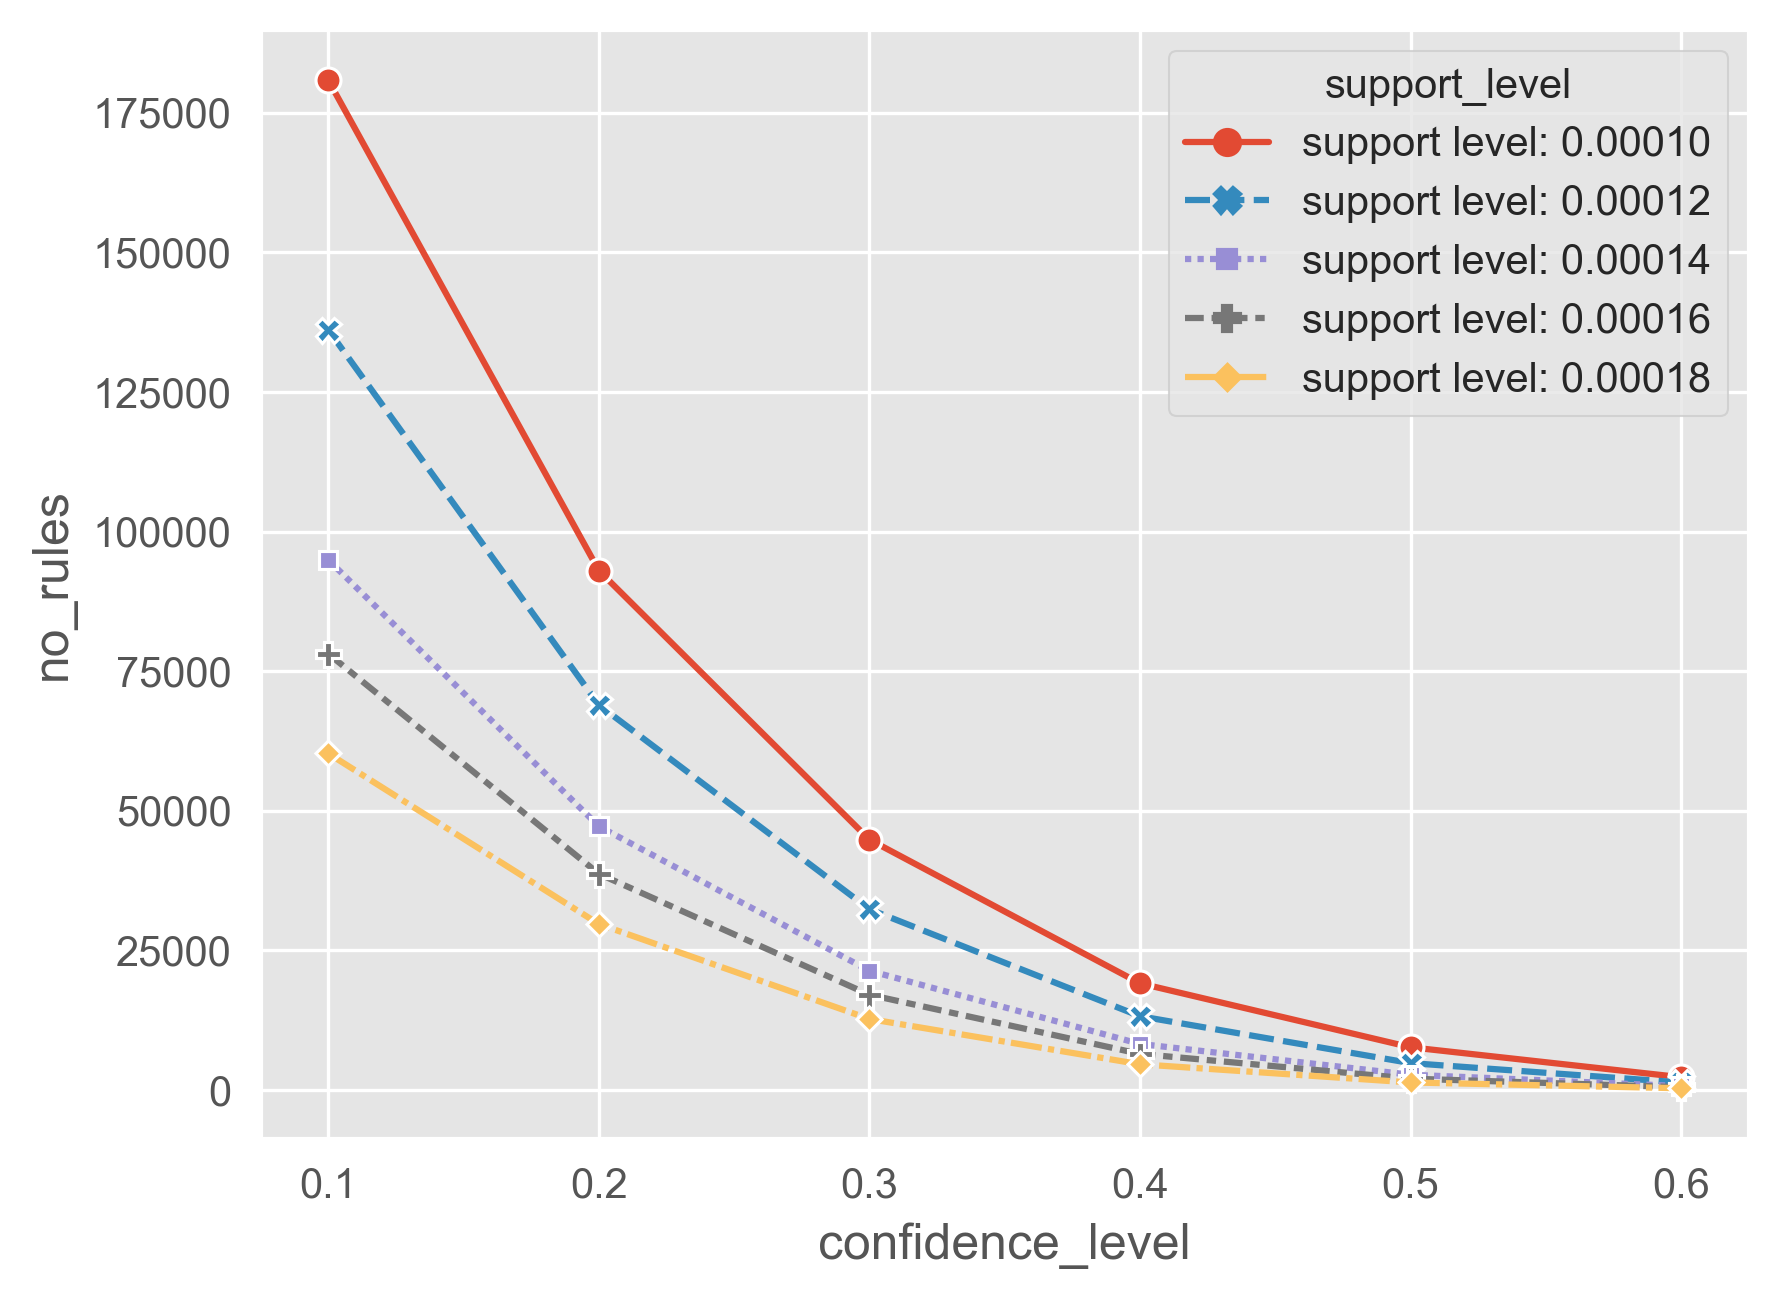

In [10]:
sns.lineplot(data=report.reset_index(drop=True), x='confidence_level', y='no_rules',
             hue='support_level', style='support_level', markers=True)
plt.savefig('media/fig3_threshold.png')

In [11]:
frequent_itemsets = fpgrowth(df_te, min_support=0.00018, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(f'No. Rules: {rules.shape[0]}')

No. Rules: 12809


In [12]:
for i in ['antecedents', 'consequents']:
    rules[f'combo_{i}'] = rules[i].map(lambda x: len(x))
    rules[i] = rules[i].map(lambda x: ' + '.join(tuple(x)))
rules['combo'] = rules['combo_antecedents'].astype(str) + ' - ' + rules['combo_consequents'].astype(str)
rules.drop(columns=['combo_antecedents', 'combo_consequents'], inplace=True)

In [13]:
rules['combo'].value_counts()

2 - 1    6911
3 - 1    5015
1 - 1     596
4 - 1     263
3 - 2      12
2 - 2      10
1 - 2       2
Name: combo, dtype: int64

In [14]:
rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,combo
11340,Sparkling Lemon Water + Pure Sparkling Water +...,Sparkling Water Grapefruit,0.000217,0.026890,0.000193,0.888889,33.056885,0.000187,8.757993,3 - 1
2435,Organic Yellow Onion + Organic Raspberries + O...,Bag of Organic Bananas,0.000281,0.123633,0.000233,0.828571,6.701863,0.000198,5.112141,4 - 1
10289,Organic Raspberries + Organic Navel Orange + O...,Bag of Organic Bananas,0.000394,0.123633,0.000322,0.816327,6.602821,0.000273,4.771331,3 - 1
1192,Organic Grape Tomatoes + Organic Hass Avocado ...,Bag of Organic Bananas,0.000281,0.123633,0.000225,0.800000,6.470764,0.000190,4.381835,4 - 1
11810,Lime Sparkling Water + Sparkling Lemon Water +...,Sparkling Water Grapefruit,0.000241,0.026890,0.000193,0.800000,29.751196,0.000187,4.865552,3 - 1
...,...,...,...,...,...,...,...,...,...,...
2582,Organic Raspberries + Fresh Cauliflower + Orga...,Organic Lemon,0.000643,0.028120,0.000193,0.300000,10.668573,0.000175,1.388400,3 - 1
12468,Organic Yellow Onion + Organic Orange Bell Pepper,Organic Baby Spinach,0.000643,0.078369,0.000193,0.300000,3.828032,0.000143,1.316615,2 - 1
1574,Organic Yellow Onion + Large Lemon + Organic B...,Bag of Organic Bananas,0.000885,0.123633,0.000265,0.300000,2.426537,0.000156,1.251953,3 - 1
8287,Organic Bosc Pear + Organic Zucchini,Organic Strawberries,0.000643,0.087271,0.000193,0.300000,3.437575,0.000137,1.303899,2 - 1


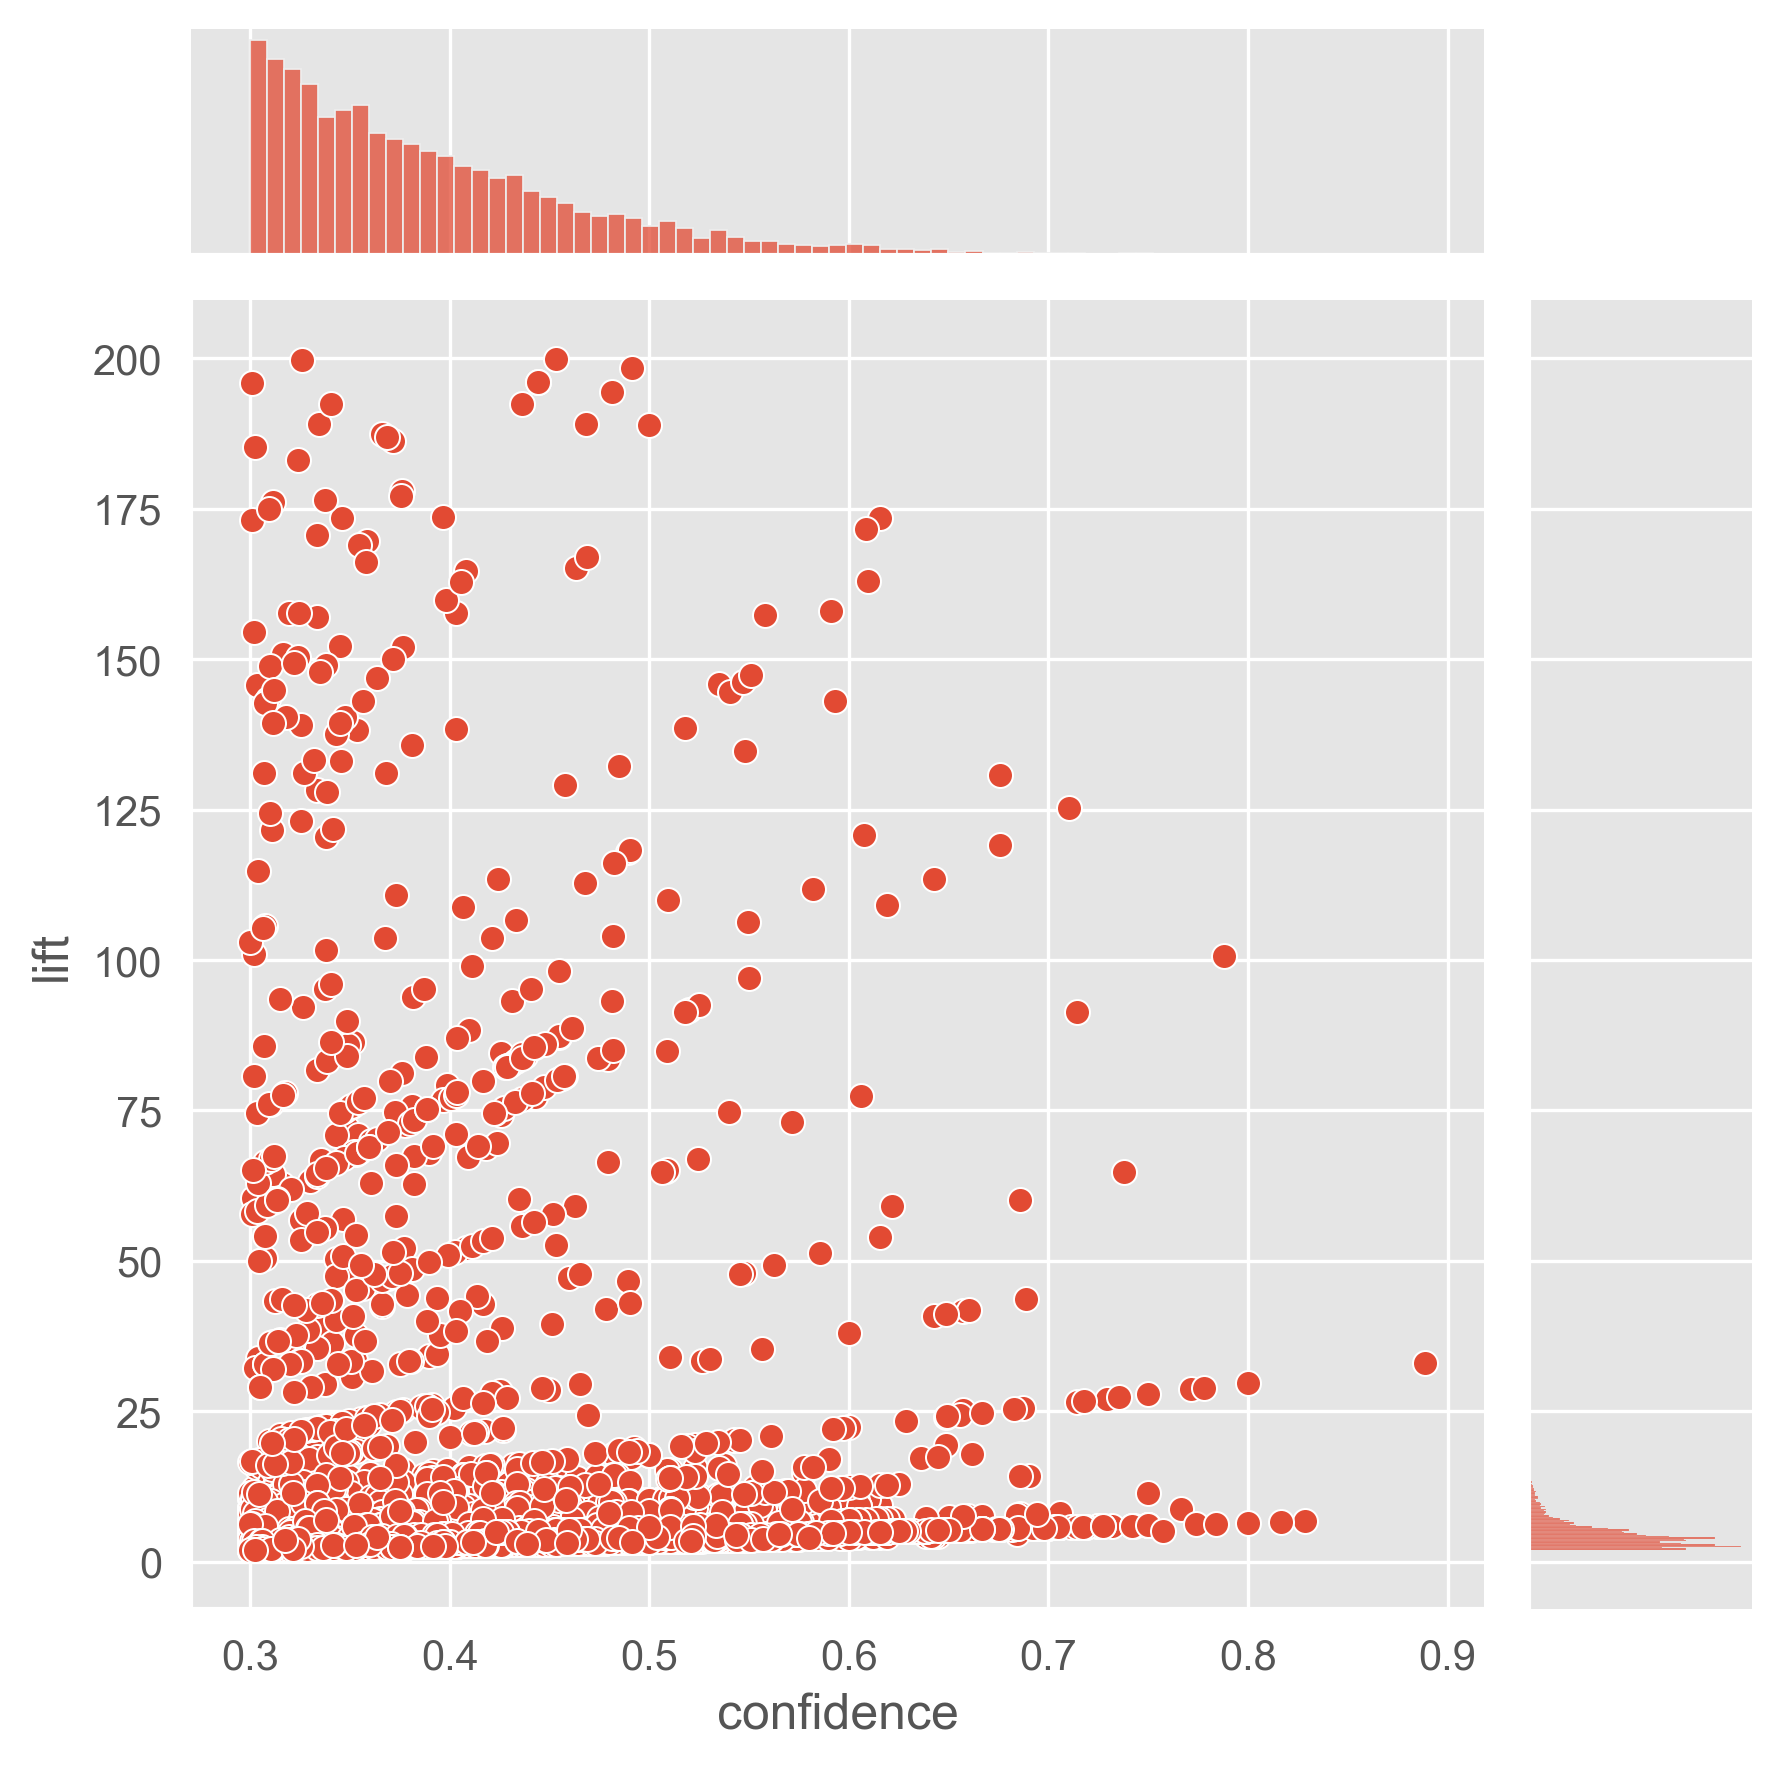

In [15]:
sns.jointplot(data=rules.query('lift < 200'), x='confidence', y='lift')
plt.savefig('media/fig4_correlation.png')